In [19]:
# Imports / Cell 1
from __future__ import annotations

import gc
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
config_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(config_path)
import config as config  # must live in PYTHONPATH or same dir
import numpy as np
import pandas as pd
import torch
from packaging import version
import optuna
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
)
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

In [20]:
print(torch.__version__)
print(torch.version.cuda)

2.8.0+cu129
12.9


In [21]:
# Project paths / Cell 2
CSV_PATH = str(config.PROCESSED_CSV)
OUTPUT_PLOT = str(config.TCN_CONFUSION_MATRIX_PLOT)
OUTPUT_PREDICTIONS = str(config.PREDICTIONS_CSV)
OUTPUT_SHAP = str(config.OUTPUTS_DIR / "shap_feature_importance.csv")

In [22]:
# Collect and sort data / Cell 3
df = pd.read_csv(CSV_PATH)
df = df.sort_values("timestamp").reset_index(drop=True)

In [23]:
# Downcast for efficiency and training speed / Cell 4
to_cast = [
    c for c in df.select_dtypes("float64").columns
    if c not in ("timestamp", "mid_price")
]
df[to_cast] = df[to_cast].astype("float32")


In [24]:
# --- 3-class labels from future-window targets --- / Cell 5
DZ = 0.08  # 0.5% deadzone to avoid micro-noise; tune 0.003–0.01

def to_dir(max_rel: float, min_rel: float, dz: float = DZ) -> int:
    # UP if upside exceeds DZ; DOWN if downside exceeds DZ; otherwise FLAT
    if max_rel > dz:  return 1
    if min_rel < -dz: return -1
    return 0

y_dir = np.array([to_dir(mx, mn, DZ) for mx, mn in zip(
    df["target_max_rel"].values, df["target_min_rel"].values
)], dtype=np.int8)

# Features: keep only numeric features not in passthrough/targets
passthrough = {"item", "timestamp", "mid_price",
               "target_min_abs", "target_max_abs", "target_min_rel", "target_max_rel"}
feature_cols = [c for c in df.columns
                if c not in passthrough and pd.api.types.is_numeric_dtype(df[c])]
X = df[feature_cols].astype("float32")

# Clean NaNs/Infs
mask = np.isfinite(X).all(axis=1)
X, y_dir = X[mask], y_dir[mask]
df = df.loc[mask].reset_index(drop=True)

# Encode labels into {0,1,2} but preserve semantic mapping {-1,0,1}
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.classes_ = np.array([-1, 0, 1])  # fix class order
y = le.transform(y_dir)             # -1→0, 0→1, 1→2

print(f"Rows: {len(X):,} | Features: {len(feature_cols)} | Class counts (−1,0,1):",
      {k:int(v) for k,v in zip(le.classes_, np.bincount(y, minlength=3))})

Rows: 1,493,600 | Features: 93 | Class counts (−1,0,1): {np.int64(-1): 284916, np.int64(0): 905306, np.int64(1): 303378}


In [25]:
# ==== TCN: imports and config ==== / Cell 6
import math, time, gc
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("TCN device:", DEVICE)

# Window / model config (tweak as needed)
SEQ_LEN = 120          # minutes of history per sample (60–240 are sensible)
BATCH_SIZE = 4096      # bump on GPU, reduce on CPU
EPOCHS = 30
PATIENCE = 5
LR = 2e-3
DROPOUT = 0.30
HIDDEN = 128
LEVELS = 3             # dilated residual blocks
KERNEL_SIZE = 3
WEIGHT_DECAY = 1e-3    # small L2

# We'll reuse: df, feature_cols, le (classes [-1,0,1]), and the earlier TSCV split indices train_idx/val_idx

# ---- Dataset that builds per-item causal windows without crossing item boundaries
class SeqDataset(Dataset):
    def __init__(self, df_sorted: pd.DataFrame, X_float32: pd.DataFrame, y_enc: np.ndarray,
                 end_indices: np.ndarray, seq_len: int):
        """
        df_sorted must be sorted by ["item","timestamp"].
        Builds windows that DO NOT cross item boundaries using a simple cumcount mask.
        """
        self.seq_len = int(seq_len)
        self.values = X_float32.values.astype("float32")  # (N, F)
        self.y = y_enc.astype("int64")
        self.df_index = df_sorted.index.values           # map back to df rows

        # Precompute per-item position: pos=0,1,2,... within each item
        pos_in_item = df_sorted.groupby("item").cumcount().to_numpy()
        # Valid if we have at least seq_len elements inside the same item up to this end
        valid_mask = pos_in_item >= (self.seq_len - 1)

        # Restrict to provided end_indices (TSCV) and validity
        end_indices = np.asarray(end_indices, dtype=np.int64)
        end_indices = end_indices[(end_indices >= 0) & (end_indices < len(df_sorted))]
        ends = end_indices[valid_mask[end_indices]]

        # Keep only ends whose entire window has all-finite features
        # (cheap check on start index; avoids NaNs from early EMAs)
        start_idx = ends - (self.seq_len - 1)
        finite_mask = np.isfinite(self.values[start_idx, :]).all(axis=1) & np.isfinite(self.values[ends, :]).all(axis=1)
        self.ends = ends[finite_mask]

    def __len__(self):
        return int(len(self.ends))

    def __getitem__(self, i):
        end = int(self.ends[i])
        start = end - (self.seq_len - 1)
        x = self.values[start:end+1]        # (L, F)
        # (F, L) for Conv1d
        x = torch.from_numpy(x.T.copy())
        y = torch.tensor(self.y[end], dtype=torch.long)
        meta = int(self.df_index[end])
        return x, y, meta

# ---- TCN modules (CAUSAL: left-only padding, no Chomp, no symmetric padding)

class CausalConv1d(nn.Module):
    """
    Left-only padding so that output at time t only depends on inputs <= t.
    """
    def __init__(self, in_ch, out_ch, kernel_size=3, dilation=1, bias=True):
        super().__init__()
        self.left_pad = (kernel_size - 1) * dilation
        self.pad = nn.ConstantPad1d((self.left_pad, 0), 0.0)   # (left, right)
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size=kernel_size,
                              dilation=dilation, padding=0, bias=bias)

    def forward(self, x):
        return self.conv(self.pad(x))

class TemporalBlock(nn.Module):
    """
    Residual block with TWO causal convolutions (no future peeking).
    """
    def __init__(self, n_inputs, n_outputs, kernel_size, dilation, dropout):
        super().__init__()
        self.conv1 = CausalConv1d(n_inputs, n_outputs, kernel_size=kernel_size,
                                  dilation=dilation, bias=False)
        self.relu1 = nn.ReLU(inplace=True)
        self.drop1 = nn.Dropout(dropout)

        self.conv2 = CausalConv1d(n_outputs, n_outputs, kernel_size=kernel_size,
                                  dilation=dilation, bias=False)
        self.relu2 = nn.ReLU(inplace=True)
        self.drop2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, kernel_size=1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv1(x); out = self.relu1(out); out = self.drop1(out)
        out = self.conv2(out); out = self.relu2(out); out = self.drop2(out)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_features, num_classes=3,
                 channels=HIDDEN, levels=LEVELS, kernel_size=KERNEL_SIZE, dropout=DROPOUT):
        super().__init__()
        layers = []
        in_ch = num_features
        for i in range(levels):
            out_ch = channels
            dilation = 2 ** i
            # NOTE: no symmetric padding; dilation only affects left-pad inside CausalConv1d
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation, dropout))
            in_ch = out_ch
        self.network = nn.Sequential(*layers)

        # Channel-wise normalization improves stability on non-stationary tabular features
        # GroupNorm(num_groups=1) == LayerNorm over channels for 1D conv input
        self.chan_norm = nn.GroupNorm(1, in_ch)

        # Lightweight attention pooling over time (instead of "last step only")
        self.attn_score = nn.Conv1d(in_ch, 1, kernel_size=1)  # (B,1,L)
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv1d(in_ch, num_classes, kernel_size=1)
        )

    def forward(self, x):                 # x: (B,F,L)
        z = self.network(x)               # (B,C,L)
        z = self.chan_norm(z)             # (B,C,L)

        # attention weights over L
        att = self.attn_score(z)          # (B,1,L)
        att = torch.softmax(att, dim=-1)  # (B,1,L)
        # attention-weighted average over time
        z_pool = (z * att).sum(dim=-1, keepdim=True)  # (B,C,1)

        logits = self.head(z_pool).squeeze(-1)        # (B,num_classes)
        return logits


TCN device: cuda


In [26]:
## Labels and preprocessing / Cell 7  (REPLACED: causal feature shift + safe split/scale)
import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# --- Stable sort ---
df_seq = df.sort_values(["item","timestamp"]).reset_index(drop=True)

# --- Labels (same as your Cell 5 semantics: {-1,0,1} from targets) ---
DZ = 0.08
y_dir_seq = np.where(df_seq["target_max_rel"].values > DZ, 1,
              np.where(df_seq["target_min_rel"].values < -DZ, -1, 0)).astype(np.int8)
le = LabelEncoder(); le.classes_ = np.array([-1,0,1]); y_seq = le.transform(y_dir_seq)

# --- Feature selection (exclude passthrough/targets) ---
passthrough = {"item","timestamp","mid_price",
               "target_min_abs","target_max_abs","target_min_rel","target_max_rel"}
feature_cols = [c for c in df_seq.columns
                if c not in passthrough and pd.api.types.is_numeric_dtype(df_seq[c])]

# --- Causal sanitation: per-item shift(1) on ALL predictors ---
# If a column is already lagged (name contains 'lag'/'shift'), we still shift again – strictly causal.
X_seq = df_seq[["item"] + feature_cols].copy()
for c in feature_cols:
    X_seq[c] = X_seq.groupby("item", sort=False)[c].shift(1)

# Drop the first row per item created by shift(1) (now NaNs)
valid = np.isfinite(X_seq[feature_cols]).all(axis=1)
df_seq = df_seq.loc[valid].reset_index(drop=True)
X_seq = X_seq.loc[valid, feature_cols].astype("float32")
y_seq = y_seq[valid.to_numpy()]

# --- Pure time split (80/20 by timestamp) ---
ts = df_seq["timestamp"].to_numpy()
cutoff = np.quantile(ts, 0.80)
is_train = ts < cutoff
is_val   = ~is_train

# --- Train-only scaling ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_seq[is_train].to_numpy())
X_val   = scaler.transform(      X_seq[is_val  ].to_numpy())
X_all = np.empty_like(X_seq.to_numpy(), dtype="float32")
X_all[is_train] = X_train
X_all[is_val]   = X_val

# --- Build end indices that do NOT cross item or split ---
SEQ = SEQ_LEN  # from config

def build_end_indices(mask: np.ndarray) -> np.ndarray:
    ends = []
    sub = df_seq[mask]
    for item, g in sub.groupby("item", sort=False):
        idx = g.index.to_numpy()
        if len(idx) >= SEQ:
            starts = idx - (SEQ - 1)
            valid = starts >= idx[0]
            ends.extend(idx[valid])
    return np.array(ends, dtype=np.int64)

train_end_idx = build_end_indices(is_train)
val_end_idx   = build_end_indices(is_val)

# Boundary NaN/Inf filter (cheap)
starts_tr = train_end_idx - (SEQ - 1)
starts_va = val_end_idx   - (SEQ - 1)
finite_tr = np.isfinite(X_all[starts_tr]).all(axis=1) & np.isfinite(X_all[train_end_idx]).all(axis=1)
finite_va = np.isfinite(X_all[starts_va]).all(axis=1) & np.isfinite(X_all[val_end_idx]).all(axis=1)
train_end_idx = train_end_idx[finite_tr]
val_end_idx   = val_end_idx[finite_va]

print(f"[Split] train rows={is_train.sum()}, val rows={is_val.sum()}, "
      f"usable train_end_idx={len(train_end_idx)}, usable val_end_idx={len(val_end_idx)}")

# --- GPU hold (scaled) ---
AMP_DTYPE = torch.bfloat16 if (DEVICE=="cuda" and torch.cuda.is_bf16_supported()) else (
            torch.float16 if DEVICE=="cuda" else torch.float32)

values_gpu = torch.from_numpy(X_all).to(DEVICE).contiguous()          # [N, F]
labels_gpu = torch.from_numpy(y_seq).to(DEVICE, dtype=torch.long)     # [N]

class EndIndexDataset(Dataset):
    def __init__(self, ends: np.ndarray):
        self.ends = ends.astype(np.int64, copy=False)
    def __len__(self): return int(len(self.ends))
    def __getitem__(self, i): return int(self.ends[i])

train_ds = EndIndexDataset(train_end_idx)
val_ds   = EndIndexDataset(val_end_idx)

NUM_WORKERS = 0; PIN_MEM = False
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=PIN_MEM)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEM)

def tcn_rf(k, levels): return 1 + 2 * (k - 1) * (2**levels - 1)
rf = tcn_rf(KERNEL_SIZE, LEVELS)
print(f"[GPU-hold] {values_gpu.shape}  AMP={AMP_DTYPE}   RF={rf}  SEQ_LEN={SEQ_LEN}")
assert SEQ_LEN >= rf, f"SEQ_LEN {SEQ_LEN} < RF {rf}"


[Split] train rows=1194600, val rows=298800, usable train_end_idx=1170800, usable val_end_idx=275000
[GPU-hold] torch.Size([1493400, 93])  AMP=torch.bfloat16   RF=29  SEQ_LEN=120


In [27]:
## Train TCN / Cell 8 
import time, gc, math
import torch, torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

# Helper: build (B, L) index tensor ON GPU, then gather (B, L, F) from values_gpu
arange_L = torch.arange(SEQ_LEN, device=DEVICE)  # [0..L-1], reused
def make_batch_from_ends(ends_gpu: torch.Tensor):
    # ends_gpu: (B,) int64 on GPU
    idxs = ends_gpu.unsqueeze(1) - (SEQ_LEN - 1 - arange_L)  # (B,L)
    xBLF = values_gpu.index_select(0, idxs.reshape(-1)).reshape(ends_gpu.shape[0], SEQ_LEN, -1)
    x = xBLF.transpose(1, 2).contiguous().to(dtype=AMP_DTYPE if DEVICE=="cuda" else torch.float32)  # (B,F,L)
    y = labels_gpu.index_select(0, ends_gpu)
    return x, y

# Class weights from training end-labels (use the new variable name)
classes = np.array([0, 1, 2], dtype=int)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=labels_gpu[train_end_idx].cpu().numpy())
class_weights = torch.tensor(cw, dtype=torch.float32, device=DEVICE)

# Loss with a touch more smoothing (robust to noisy labels)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.10)

# Model/optim
model = TCN(num_features=values_gpu.shape[1]).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

steps_per_epoch = max(len(train_dl), 1)
warmup_steps = max(steps_per_epoch // 2, 1)

def lr_lambda(step):
    if step < warmup_steps:
        return (step + 1) / warmup_steps
    progress = (step - warmup_steps) / max(1, EPOCHS * steps_per_epoch - warmup_steps)
    return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

# CUDA fast-math
if DEVICE == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True

from torch.amp import GradScaler, autocast
scaler = GradScaler(device="cuda", enabled=(DEVICE=="cuda" and AMP_DTYPE in (torch.float16, torch.bfloat16)))

def eval_epoch():
    model.eval()
    tot_loss, n = 0.0, 0
    yh_all, y_all = [], []
    with torch.no_grad(), autocast(device_type="cuda", enabled=(DEVICE=="cuda"), dtype=AMP_DTYPE):
        for ends in val_dl:
            ends_gpu = ends.to(DEVICE, dtype=torch.long, non_blocking=True)
            xb, yb = make_batch_from_ends(ends_gpu)
            logits = model(xb)
            loss = criterion(logits, yb)
            bs = yb.size(0)
            tot_loss += float(loss.item()) * bs; n += bs
            yh_all.append(logits.argmax(1).detach().cpu().numpy())
            y_all.append(yb.detach().cpu().numpy())
    yh_all = np.concatenate(yh_all) if yh_all else np.array([], dtype=int)
    y_all  = np.concatenate(y_all)  if y_all  else np.array([], dtype=int)
    macro_f1 = f1_score(y_all, yh_all, average="macro") if len(y_all) else 0.0
    return tot_loss / max(n, 1), macro_f1

best_f1, best_state, patience_ctr = -1.0, None, 0
for ep in range(1, EPOCHS + 1):
    t0 = time.time()
    model.train()
    seen, running = 0, 0.0

    for step, ends in enumerate(train_dl, 1):
        ends_gpu = ends.to(DEVICE, dtype=torch.long, non_blocking=True)
        xb, yb = make_batch_from_ends(ends_gpu)
        with autocast(device_type="cuda", enabled=(DEVICE=="cuda"), dtype=AMP_DTYPE):
            logits = model(xb)
            loss = criterion(logits, yb)

        opt.zero_grad(set_to_none=True)
        if scaler.is_enabled():
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt); scaler.update()
        else:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        scheduler.step()

        running += float(loss.item()) * yb.size(0)
        seen += yb.size(0)
        if step % 50 == 0:
            print(f"[TCN] ep{ep} step{step} seen {seen} loss {running/max(seen,1):.4f}", end="\r")

    vloss, vf1 = eval_epoch()
    dt = time.time() - t0
    print(f"[TCN] epoch {ep:02d} train_loss={running/max(seen,1):.4f} val_loss={vloss:.4f} "
          f"val_macroF1={vf1:.4f} time={dt:.1f}s")

    if vf1 > best_f1 + 1e-4:
        best_f1, patience_ctr = vf1, 0
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    else:
        patience_ctr += 1
        if patience_ctr >= PATIENCE:
            print("[TCN] early stop.")
            break

if best_state is not None:
    model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})
gc.collect()


[TCN] epoch 01 train_loss=0.8078 val_loss=1.4282 val_macroF1=0.5115 time=11.1s
[TCN] epoch 02 train_loss=0.5067 val_loss=1.5677 val_macroF1=0.5056 time=9.7s
[TCN] epoch 03 train_loss=0.4513 val_loss=1.5898 val_macroF1=0.5138 time=9.6s
[TCN] epoch 04 train_loss=0.4310 val_loss=1.7064 val_macroF1=0.4881 time=9.6s
[TCN] epoch 05 train_loss=0.4206 val_loss=1.6694 val_macroF1=0.5017 time=9.6s
[TCN] epoch 06 train_loss=0.4130 val_loss=1.6688 val_macroF1=0.5127 time=9.6s
[TCN] epoch 07 train_loss=0.4079 val_loss=1.7306 val_macroF1=0.5008 time=9.6s
[TCN] epoch 08 train_loss=0.3983 val_loss=1.7500 val_macroF1=0.5023 time=9.6s
[TCN] early stop.


629

In [28]:
## Convert TCN output into backtest format / Cell 9  (REPLACED: safe BF16→FP32)
model.eval()
all_meta, all_logits = [], []

with torch.no_grad(), torch.amp.autocast(device_type="cuda", enabled=(DEVICE=="cuda"), dtype=AMP_DTYPE):
    for ends in val_dl:
        ends_gpu = ends.to(DEVICE, dtype=torch.long, non_blocking=True)
        xb, yb = make_batch_from_ends(ends_gpu)            # reuse helper from Cell 8
        logits = model(xb).detach().cpu()                  # may be bfloat16/float16
        all_logits.append(logits)
        all_meta.append(ends.cpu())

# Concatenate and cast to float32 BEFORE NumPy
logits_t = torch.cat(all_logits, dim=0)                    # (N, 3), cpu, bf16/fp16/fp32
logits_f32 = logits_t.to(torch.float32)                    # safe for softmax & numpy
meta_idx = torch.cat(all_meta, dim=0).numpy()              # (N,)

# Probabilities & predictions
proba = torch.softmax(logits_f32, dim=1).cpu().numpy()     # (N,3) float32
pred_y = proba.argmax(axis=1)                              # 0/1/2

# Build predictions DataFrame consistent with backtester expectations
val_rows = df_seq.iloc[meta_idx].copy()
pred_df = pd.DataFrame({
    "timestamp": val_rows["timestamp"].values,
    "item": val_rows["item"].values,
    "mid_price": val_rows["mid_price"].values if "mid_price" in val_rows.columns else np.nan,
    "true_dir": le.inverse_transform(y_seq[meta_idx]),
    "pred_dir": le.inverse_transform(pred_y),
})

buy_idx = int(np.where(le.classes_ == 1)[0][0])    # class index for +1
pred_df["pred_label"] = pred_df["pred_dir"].astype("int8")
pred_df["pred_proba_buy"] = proba[:, buy_idx].astype("float32")

pred_df.to_csv(OUTPUT_PREDICTIONS, index=False)
print("TCN predictions saved →", OUTPUT_PREDICTIONS)
pred_df.head(3)


TCN predictions saved → C:\Users\reyno\Documents\GitHub\Project-BLD\Outputs\xgb_predictions.csv


,timestamp,item,mid_price,true_dir,pred_dir,pred_label,pred_proba_buy
0,1.754519e+09,AGARIMOO_TONGUE,8690.227,1,1,1,0.672585
1,1.754519e+09,AGARIMOO_TONGUE,8690.227,1,1,1,0.664980
2,1.754519e+09,AGARIMOO_TONGUE,8690.410,1,1,1,0.651924


TCN macro-F1: 0.5137657165767998
TCN weighted-F1: 0.6167286623264617
              precision    recall  f1-score   support

          -1     0.4314    0.3493    0.3860     55927
           0     0.7449    0.7733    0.7588    168769
           1     0.3811    0.4130    0.3964     50304

    accuracy                         0.6212    275000
   macro avg     0.5191    0.5119    0.5138    275000
weighted avg     0.6146    0.6212    0.6167    275000



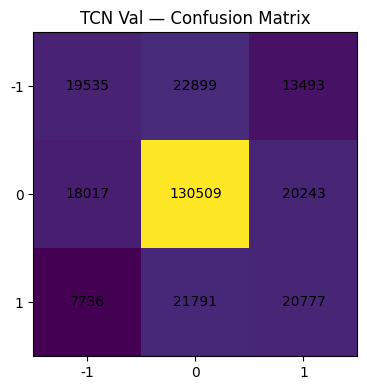

In [29]:
## TCN conf. matrix and F1 / Cell 10  (REPLACED)
from sklearn.metrics import classification_report, confusion_matrix, f1_score

y_val_true = y_seq[meta_idx]
y_val_hat  = pred_y

print("TCN macro-F1:", f1_score(y_val_true, y_val_hat, average="macro"))
print("TCN weighted-F1:", f1_score(y_val_true, y_val_hat, average="weighted"))
print(classification_report(y_val_true, y_val_hat, target_names=["-1","0","1"], digits=4))

cm = confusion_matrix(y_val_true, y_val_hat, labels=[0,1,2])
fig = plt.figure(figsize=(4,4)); ax = plt.gca(); ax.imshow(cm)
ax.set_title("TCN Val — Confusion Matrix")
ax.set_xticks([0,1,2]); ax.set_xticklabels(["-1","0","1"])
ax.set_yticks([0,1,2]); ax.set_yticklabels(["-1","0","1"])
for (i,j),v in np.ndenumerate(cm): ax.text(j,i,str(v),ha="center",va="center")
plt.tight_layout(); plt.show()


In [ ]:
# --- Inline backtest with per-minute equity snapshots (no seaborn)  (REPLACED)

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import os, math, gc

# Inputs/outputs from your config
PRED_PATH = OUTPUT_PREDICTIONS
TRADE_LOG_PATH = str(config.TCN_TRADE_LOG_CSV)
PLOTS_DIR = str(config.TCN_TRADING_DIR)
Path(PLOTS_DIR).mkdir(parents=True, exist_ok=True)

def run_backtest(
    df_sim: pd.DataFrame,
    *,
    initial_capital: float = 1_000_000_000.0,
    min_trade_amount: float = 75_000.0,
    max_trades_per_minute: int = 2,
    min_confidence: float = 0.90,
    exit_profit_threshold: float = 0.50,
    fee_bps: float = 200,        # roundtrip fee split equally per side
    slippage_bps: float = 0.0,   # per side slippage
    max_positions_per_item: int = 1,
    cooldown_minutes: int = 0,
    bar_seconds: int = 60,       # bar size in seconds
):
    """
    Long-only minute-paced backtest on predictions with strict causality:
      • Signals at t execute at t+1 bar (T+1).
      • No exits allowed on the same bar as entry.
      • One decision per (item, timestamp) after dedup (keep last by timestamp).
    Expects df_sim columns: timestamp (epoch secs), item, mid_price, pred_label in {-1,0,1}, pred_proba_buy [0..1].
    Returns (trades_df, summary_dict, equity_df[minute, capital, invested, equity, npos]).
    """

    required = {"timestamp","item","mid_price","pred_label","pred_proba_buy"}
    missing = required - set(df_sim.columns)
    if missing:
        raise ValueError(f"Backtest missing columns: {sorted(missing)}")

    # 0) Clean & dedup predictions (keep last per (item,timestamp))
    df = df_sim.copy()
    df = df.sort_values(["timestamp","item"]).drop_duplicates(["item","timestamp"], keep="last").reset_index(drop=True)

    # 1) Enforce T+1 execution: shift the *effective* decision time to next bar
    df["exec_time"] = (df["timestamp"] + bar_seconds).astype("float64")
    df["exec_minute"] = (df["exec_time"] // bar_seconds).astype("int64")

    # 2) State
    capital = float(initial_capital)
    inventory = []          # dicts: item, entry_time, entry_price, size, confidence
    trade_log = []
    last_seen = {}          # item -> (price, ts) from raw mid stream
    last_exit_minute = {}   # item -> minute index

    # 3) Fees/slippage
    fee_buy_mult  = 1.0 + (fee_bps / 20000.0) + (slippage_bps / 10000.0)
    fee_sell_mult = 1.0 - (fee_bps / 20000.0) - (slippage_bps / 10000.0)

    # 4) Equity snapshots per minute
    equity_rows = []
    current_minute = None
    trades_this_minute = 0

    def snapshot(minute: int, ts: float):
        if minute is None:
            return
        invested = 0.0
        for pos in inventory:
            px = last_seen.get(pos["item"], (pos["entry_price"], ts))[0]
            invested += pos["size"] * px
        equity = capital + invested
        invested_pct = invested / equity if equity > 0 else 0.0
        equity_rows.append({
            "minute": minute,
            "timestamp": ts,
            "capital": capital,
            "invested": invested,
            "equity": equity,
            "invested_pct": invested_pct,
            "num_positions": len(inventory),
        })

    # 5) Iterate *raw* rows to keep last_seen updated each timestamp
    #    Then apply entries/exits at exec_time (next bar).
    #    We do this by iterating df in order and, at each row, first handle exits/entries whose exec_time == current ts.
    exec_idx = 0  # pointer into df for rows whose exec_time <= current ts

    # Build a merged timeline of *all* timestamps we will see (original and exec_time)
    timeline = np.unique(np.concatenate([df["timestamp"].to_numpy(), df["exec_time"].to_numpy()]))
    timeline.sort()

    # Per-minute counters
    minute_of = lambda ts: int(ts // bar_seconds)

    for ts in timeline:
        minute = minute_of(ts)

        # minute boundary snapshot BEFORE applying new actions at this ts
        if current_minute is None:
            current_minute = minute
            trades_this_minute = 0
        elif minute != current_minute:
            snapshot(current_minute, ts)
            current_minute = minute
            trades_this_minute = 0

        # (A) Update last_seen prices for all raw rows at this exact timestamp
        raw_rows = df[df["timestamp"] == ts]
        for _, row in raw_rows.iterrows():
            last_seen[str(row["item"])] = (float(row["mid_price"]), float(row["timestamp"]))

        # (B) Handle EXITS for positions whose *decision time* is now (exec_time == ts)
        #     Exit rules: tp (>= exit_profit_threshold) or flip_down prediction at exec ts.
        exec_rows = df[df["exec_time"] == ts]
        for _, row in exec_rows.iterrows():
            item = str(row["item"])
            price = float(row["mid_price"])  # price observed at this ts
            pred  = int(row["pred_label"])
            # update last_seen already done in (A) if raw row exists; if not, we still use row mid_price

            updated = []
            for pos in inventory:
                if pos["item"] != item:
                    updated.append(pos)
                    continue

                # FORBID same-bar exits: must be strictly after entry bar
                if minute_of(ts) <= minute_of(pos["entry_time"]):
                    updated.append(pos)
                    continue

                exit_price = price * fee_sell_mult
                held_ret = (exit_price - pos["entry_price"]) / pos["entry_price"]
                should_exit = (held_ret >= exit_profit_threshold) or (pred == -1)
                if should_exit:
                    pnl = (exit_price - pos["entry_price"]) * pos["size"]
                    capital += pos["size"] * exit_price
                    dur_sec = float(ts - pos["entry_time"])
                    trade_log.append({
                        "item": item,
                        "entry_time": pos["entry_time"],
                        "exit_time": ts,
                        "duration_sec": dur_sec,
                        "duration_min": dur_sec / 60.0,
                        "entry_price": pos["entry_price"],
                        "exit_price": exit_price,
                        "size": pos["size"],
                        "pnl": pnl,
                        "return": held_ret,
                        "confidence": pos["confidence"],
                        "reason": ("tp" if held_ret >= exit_profit_threshold else "flip_down")
                    })
                    last_exit_minute[item] = minute
                else:
                    updated.append(pos)
            inventory = updated

        # (C) Handle ENTRIES for predictions whose exec_time == ts
        for _, row in exec_rows.iterrows():
            item = str(row["item"])
            price = float(row["mid_price"])
            pred = int(row["pred_label"])
            conf = float(row["pred_proba_buy"])

            if pred != 1 or trades_this_minute >= max_trades_per_minute or conf < min_confidence or price <= 0:
                continue

            # cooldown
            if cooldown_minutes > 0 and item in last_exit_minute:
                if minute - last_exit_minute[item] < cooldown_minutes:
                    continue

            # max positions per item
            n_open = sum(1 for p in inventory if p["item"] == item)
            if n_open >= max_positions_per_item:
                continue

            # budget & size
            alpha = 4.0
            scaled = ((conf - min_confidence) / max(1e-6, 1.0 - min_confidence)) ** alpha
            budget = float(scaled * capital)
            if budget < min_trade_amount:
                continue

            entry_price = price * fee_buy_mult
            size = int(budget / entry_price)
            if size < 1:
                continue

            cost = size * entry_price
            capital -= cost
            inventory.append({
                "item": item,
                "entry_time": ts,                 # EXECUTION time (t+1)
                "entry_price": entry_price,       # EXECUTION price at ts
                "size": size,
                "confidence": conf
            })
            trades_this_minute += 1

    # final snapshot and close all at last seen prices
    if current_minute is not None and len(df):
        snapshot(current_minute, float(df["timestamp"].iloc[-1]))

    for pos in inventory:
        last_price, last_time = last_seen.get(pos["item"], (pos["entry_price"], pos["entry_time"]))
        exit_price = last_price * fee_sell_mult
        pnl = (exit_price - pos["entry_price"]) * pos["size"]
        capital += pos["size"] * exit_price
        dur_sec = float(last_time - pos["entry_time"])
        trade_log.append({
            "item": pos["item"],
            "entry_time": pos["entry_time"],
            "exit_time": last_time,
            "duration_sec": dur_sec,
            "duration_min": dur_sec / 60.0,
            "entry_price": pos["entry_price"],
            "exit_price": exit_price,
            "size": pos["size"],
            "pnl": pnl,
            "return": (exit_price - pos["entry_price"]) / pos["entry_price"],
            "confidence": pos["confidence"],
            "reason": "final_close"
        })

    trades = pd.DataFrame(trade_log).sort_values("pnl", ascending=False).reset_index(drop=True)
    eq = pd.DataFrame(equity_rows).sort_values("minute").reset_index(drop=True)

    # Invariants: forbid zero-duration unless explicitly same timestamp AFTER T+1 (should not happen)
    if len(trades):
        bad = trades[trades["duration_sec"] <= 0.0]
        if len(bad):
            print(f"[WARN] Found {len(bad)} trades with non-positive duration. Showing top 5:")
            print(bad.head())

        # Price-time consistency checks (catch unit mismatches / misalignments)
        assert (trades["exit_time"] > trades["entry_time"]).all(), "Exit must be strictly after entry (T+1)."

    gross_profit = trades.loc[trades["pnl"] > 0, "pnl"].sum()
    gross_loss   = trades.loc[trades["pnl"] < 0, "pnl"].sum()
    avg_win = trades.loc[trades["pnl"] > 0, "return"].mean() if (trades["pnl"] > 0).any() else 0.0
    avg_loss = trades.loc[trades["pnl"] < 0, "return"].mean() if (trades["pnl"] < 0).any() else 0.0
    avg_duration = trades["duration_min"].mean() if len(trades) else 0.0

    summary = {
        "Final Capital": f"{capital:,.0f}",
        "Total Profit": f"{capital - initial_capital:,.0f}",
        "Num Trades": len(trades),
        "Win Rate": f"{(trades['pnl']>0).mean():.2%}" if len(trades) else "n/a",
        "Average Return / Trade": f"{trades['return'].mean():.2%}" if len(trades) else "n/a",
        "Average Win": f"{avg_win:.2%}",
        "Average Loss": f"{avg_loss:.2%}",
        "Gross Profit": f"{gross_profit:,.0f}",
        "Gross Loss": f"{gross_loss:,.0f}",
        "Profit Factor": f"{abs(gross_profit/gross_loss):.2f}" if gross_loss < 0 else "∞",
        "Average Duration (min)": f"{avg_duration:.2f}",
    }

    return trades, summary, eq

# --- Load predictions and ensure required columns exist
preds = pd.read_csv(PRED_PATH)

# Safety: enforce 1 row per (item,timestamp), keep last (latest signal of the bar)
preds = preds.sort_values(["timestamp"]).drop_duplicates(["item","timestamp"], keep="last")

# Safety: if notebook didn’t add these yet, decode/create them
if "pred_label" not in preds.columns and "pred_dir" in preds.columns:
    preds["pred_label"] = preds["pred_dir"].astype("int8")
if "pred_proba_buy" not in preds.columns:
    if "proba_1" in preds.columns:
        preds["pred_proba_buy"] = preds["proba_1"].astype("float32")
    else:
        preds["pred_proba_buy"] = (preds["pred_label"] == 1).astype("float32")

# Run backtest (tweak fees/slippage here if desired)
trades, summary, equity = run_backtest(
    preds,
    fee_bps=100,
    slippage_bps=0.0,
    cooldown_minutes=0,
    bar_seconds=300,
)

# Save trade log
Path(os.path.dirname(str(TRADE_LOG_PATH))).mkdir(parents=True, exist_ok=True)
trades.to_csv(TRADE_LOG_PATH, index=False)

print("[Backtest summary]")
for k, v in summary.items():
    print(f"{k}: {v}")


[Backtest summary]
Final Capital: 17,328,791,495
Total Profit: 16,328,791,495
Num Trades: 76
Win Rate: 84.21%
Average Return / Trade: 41.76%
Average Win: 51.16%
Average Loss: -8.35%
Gross Profit: 16,393,151,753
Gross Loss: -64,360,258
Profit Factor: 254.71
Average Duration (min): 233.34


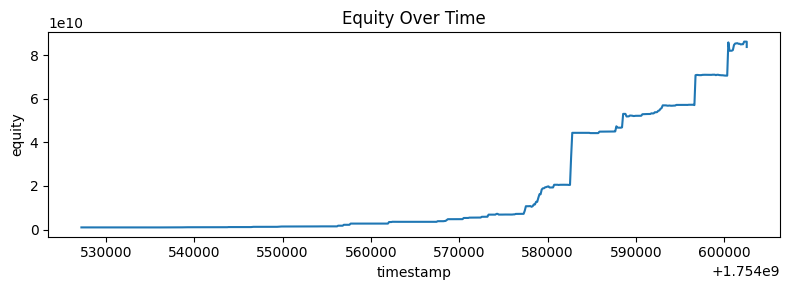

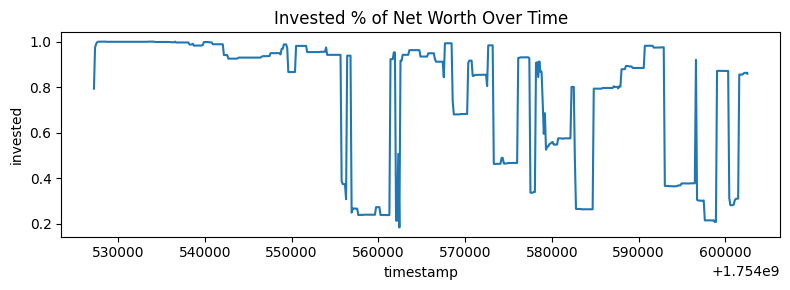

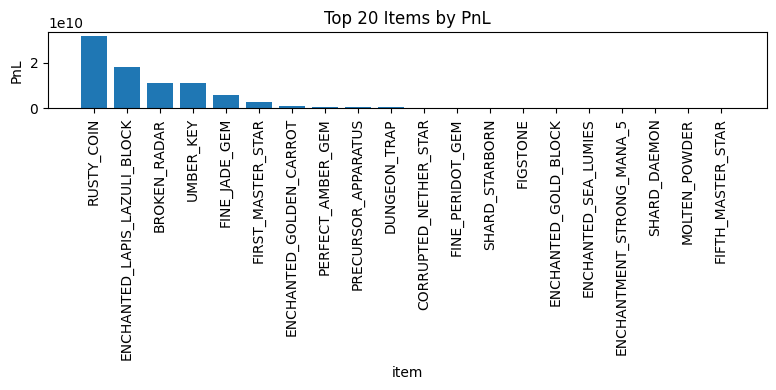

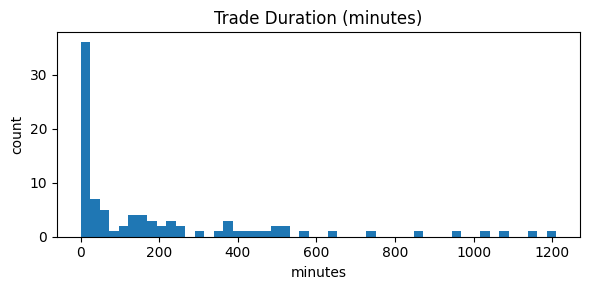

In [42]:
# --- Plots

# 1) Equity curve over time
fig = plt.figure(figsize=(8,3))
ax = plt.gca()
ax.plot(equity["timestamp"].values, equity["equity"].values)
ax.set_title("Equity Over Time")
ax.set_xlabel("timestamp")
ax.set_ylabel("equity")
plt.tight_layout()
fig.savefig(os.path.join(PLOTS_DIR, "equity_curve.png"), dpi=160)
plt.show()

# 2) Capital invested over time
fig = plt.figure(figsize=(8,3))
ax = plt.gca()
ax.plot(equity["timestamp"].values, equity["invested_pct"].values)
ax.set_title("Invested % of Net Worth Over Time")
ax.set_ylabel("invested")
ax.set_xlabel("timestamp")
plt.tight_layout()
fig.savefig(os.path.join(PLOTS_DIR, "invested_curve.png"), dpi=160)
plt.show()

# 3) Top profit items (bar)
topN = 20
pnl_by_item = trades.groupby("item", as_index=False)["pnl"].sum().sort_values("pnl", ascending=False).head(topN)
fig = plt.figure(figsize=(8,4))
ax = plt.gca()
ax.bar(range(len(pnl_by_item)), pnl_by_item["pnl"].values)
ax.set_xticks(range(len(pnl_by_item)))
ax.set_xticklabels(pnl_by_item["item"].values, rotation=90)
ax.set_title(f"Top {topN} Items by PnL")
ax.set_xlabel("item")
ax.set_ylabel("PnL")
plt.tight_layout()
fig.savefig(os.path.join(PLOTS_DIR, "top_items_pnl.png"), dpi=160)
plt.show()

# 4) Trade duration histogram (minutes)
if len(trades):
    dur_min = (trades["exit_time"].values - trades["entry_time"].values) / 60.0
    fig = plt.figure(figsize=(6,3))
    ax = plt.gca()
    ax.hist(dur_min, bins=50)
    ax.set_title("Trade Duration (minutes)")
    ax.set_xlabel("minutes")
    ax.set_ylabel("count")
    plt.tight_layout()
    fig.savefig(os.path.join(PLOTS_DIR, "trade_duration_hist.png"), dpi=160)
    plt.show()



In [44]:
# Quick forensic check (run in a new cell)
import pandas as pd
import numpy as np

tr = pd.read_csv(str(config.TCN_TRADE_LOG_CSV))
tr = tr.sort_values(["item","entry_time"]).reset_index(drop=True)

# We assume df_seq has columns: item, timestamp, mid_price, target_max_abs, target_min_abs
probe = tr.merge(
    df_seq[["item","timestamp","mid_price","target_max_abs","target_min_abs"]],
    left_on=["item","entry_time"], right_on=["item","timestamp"], how="left", suffixes=("","_at_entry")
)

probe["exit_matches_future_max"] = np.isclose(probe["exit_price"], probe["target_max_abs"], rtol=1e-6, atol=1e-6)
probe["exit_matches_future_min"] = np.isclose(probe["exit_price"], probe["target_min_abs"], rtol=1e-6, atol=1e-6)
probe["exit_equals_mid_at_entry"] = np.isclose(probe["exit_price"], probe["mid_price"], rtol=1e-6, atol=1e-6)

print("Counts:",
      probe[["exit_matches_future_max","exit_matches_future_min","exit_equals_mid_at_entry"]].sum())

# Show suspicious rows (same timestamp, different prices)
sus = probe[(probe["entry_time"]==probe["exit_time"]) &
            (~probe["exit_equals_mid_at_entry"])]
sus.head(10)


Counts: exit_matches_future_max     0
exit_matches_future_min     0
exit_equals_mid_at_entry    0
dtype: int64


,item,entry_time,exit_time,duration,entry_price,exit_price,size,pnl,return,confidence,reason,timestamp,mid_price,target_max_abs,target_min_abs,exit_matches_future_max,exit_matches_future_min,exit_equals_mid_at_entry
30,ENCHANTED_LAPIS_LAZULI_BLOCK,1.754567e+09,1.754567e+09,0.0,4.754090e+04,9.317462e+04,6281,2.866254e+08,0.959883,0.998736,tp,1.754567e+09,9.364278e+04,-6.659453e+02,-4.636675e+04,False,False,False
31,ENCHANTED_LAPIS_LAZULI_BLOCK,1.754567e+09,1.754567e+09,0.0,4.754090e+04,9.317462e+04,6281,2.866254e+08,0.959883,0.998736,tp,1.754567e+09,4.730438e+04,4.567246e+04,-2.834375e+01,False,False,False
32,ENCHANTED_LAPIS_LAZULI_BLOCK,1.754567e+09,1.754567e+09,0.0,4.754090e+04,9.317462e+04,6281,2.866254e+08,0.959883,0.998736,tp,1.754567e+09,9.364283e+04,-4.687500e-02,-4.636679e+04,False,False,False
41,ENCHANTED_SEA_LUMIES,1.754536e+09,1.754536e+09,0.0,8.416971e+04,1.194898e+05,17,6.004412e+05,0.419629,0.985717,flip_down,1.754536e+09,1.200902e+05,3.373438e+01,-4.272523e+04,False,False,False
42,ENCHANTED_SEA_LUMIES,1.754536e+09,1.754536e+09,0.0,8.416971e+04,1.194898e+05,17,6.004412e+05,0.419629,0.985717,flip_down,1.754536e+09,8.375096e+04,3.637301e+04,-6.385961e+03,False,False,False
81,FINE_JADE_GEM,1.754569e+09,1.754569e+09,0.0,1.454986e+04,2.107797e+04,58098,3.792701e+08,0.448672,0.992794,flip_down,1.754569e+09,1.447747e+04,6.749535e+03,-4.544824e+01,False,False,False
82,FINE_JADE_GEM,1.754569e+09,1.754569e+09,0.0,1.454986e+04,2.107797e+04,58098,3.792701e+08,0.448672,0.992794,flip_down,1.754569e+09,1.447731e+04,6.749701e+03,-4.528223e+01,False,False,False
83,FINE_JADE_GEM,1.754569e+09,1.754569e+09,0.0,1.454986e+04,2.107797e+04,58098,3.792701e+08,0.448672,0.992794,flip_down,1.754569e+09,2.118389e+04,4.311914e+01,-6.751864e+03,False,False,False
111,FIRST_MASTER_STAR,1.754556e+09,1.754556e+09,0.0,8.841505e+06,1.211197e+07,96,3.139643e+08,0.369899,0.998173,flip_down,1.754556e+09,8.797517e+06,4.066267e+06,-6.515600e+04,False,False,False
112,FIRST_MASTER_STAR,1.754556e+09,1.754556e+09,0.0,8.841505e+06,1.211197e+07,96,3.139643e+08,0.369899,0.998173,flip_down,1.754556e+09,1.217283e+07,6.909540e+05,-3.440469e+06,False,False,False
